Alexnet model on CIFAR10 dataset with Wandb Logging.

In [1]:
!pip install wandb # install wandb into your environment 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=d67d9075037d29b0beadb5c34abe7f3112b328784c905f51badac502552b31e4
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
import wandb
import random

# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project="520",
    
    # Initial hyperparameters and run metadata
    config={
    "architecture": "Alex-Net",
    "dataset": "CIFAR-10",
    }
)



wandb: Currently logged in as: mvangara (ssmm). Use `wandb login --relogin` to force relogin


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [6]:
# set up seed to ensure uniformity and reprodusibility
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
ROOT = '.data'

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

100%|██████████| 170498071/170498071 [00:05<00:00, 29232179.10it/s]


Extracting .data/cifar-10-python.tar.gz to .data
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


In [8]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

In [9]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [11]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 40000
Number of validation examples: 10000
Number of testing examples: 10000


In [13]:
data_transforms ={
    train_transforms, test_transforms}

Logging the dataset information 

In [14]:
wandb.config["dataset_train_transforms"]= train_transforms
wandb.config["dataset_test_transforms"] =test_transforms
wandb.config["Train_dataset_size"]= len(train_data)
wandb.config["Validation_dataset_size"] = len(valid_data)

In [16]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [17]:
def plot_filter(images, filter, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title('Filtered')
        ax.axis('off')

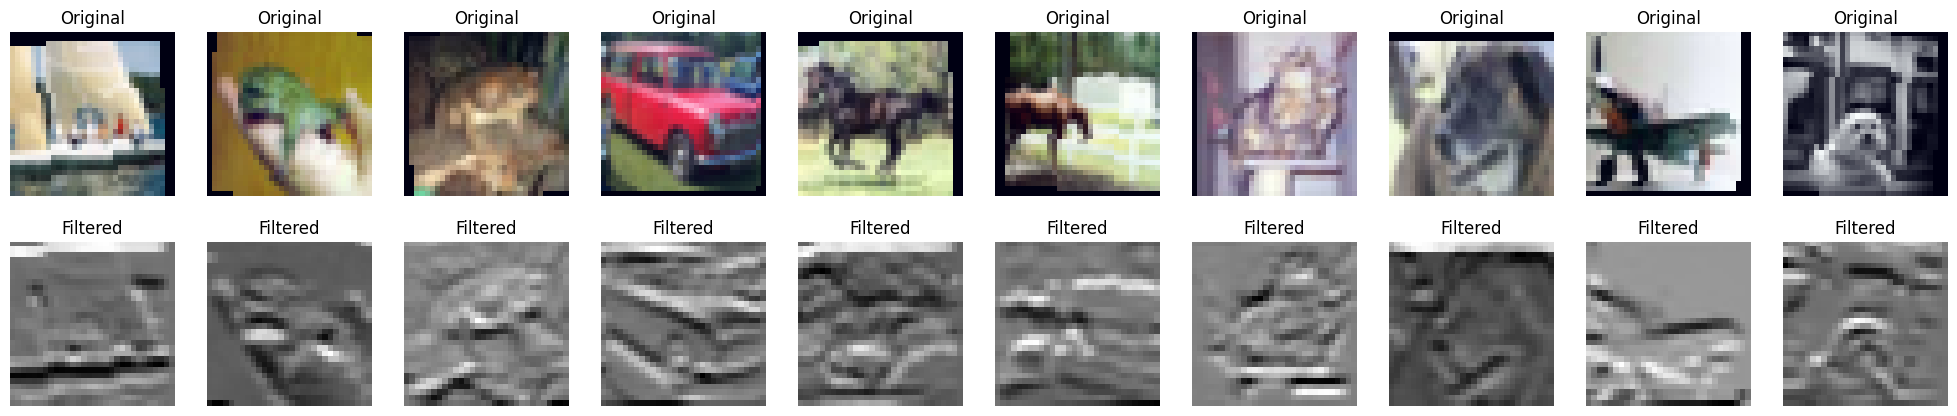

In [19]:
# Visulaising the normalisation and applying the filter
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

Alexnet Model Setup and Initilising the batch size

In [20]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

Alexnet is defined as a Class and functions defined for operations.

In [21]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

The output classes are 10 in the CIFAR10 Dataset.

In [23]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [24]:
wandb.config["model architecture"] = model

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


In [26]:
wandb.config["Output_classes"] = 10 
wandb.config["Batch_size"] = BATCH_SIZE



In [27]:
# Using the Kaimimg initialisation to initilaise parameters
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [28]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [30]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [32]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

Defining functions to perform training, validation and calaulating accuarcy

In [33]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [34]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Logging the training setup for the current experiment using wandb

In [37]:
EPOCHS = 25

wandb.config["model"] = type(model).__name__
wandb.config["criterion"] = type(criterion).__name__
wandb.config["optimizer"] = type(optimizer).__name__
wandb.config["epochs"] = EPOCHS
wandb.config["learning_rate"]=FOUND_LR
wandb.config["device"] = device

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    wandb.log({"train_loss":train_loss})
    wandb.log({"train_acc":train_acc})

    wandb.log({"valid_loss":valid_loss})
    wandb.log({"valid_acc":valid_acc})
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 2.598 | Train Acc: 19.00%
	 Val. Loss: 1.761 |  Val. Acc: 31.26%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 1.664 | Train Acc: 37.17%
	 Val. Loss: 1.442 |  Val. Acc: 47.18%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 1.436 | Train Acc: 47.53%
	 Val. Loss: 1.306 |  Val. Acc: 52.46%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 1.328 | Train Acc: 52.22%
	 Val. Loss: 1.247 |  Val. Acc: 55.08%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 1.232 | Train Acc: 55.90%
	 Val. Loss: 1.130 |  Val. Acc: 59.97%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 1.174 | Train Acc: 58.06%
	 Val. Loss: 1.132 |  Val. Acc: 59.55%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 1.111 | Train Acc: 60.49%
	 Val. Loss: 1.079 |  Val. Acc: 62.13%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 34s
	Train Loss: 1.063 | Train Acc: 62.67%
	 Val. Loss: 0.980 |  Val. Acc: 65.77%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 1.006 | Train Acc: 64.76%
	 Val. Loss: 0.962 |  Val. Acc: 66.52%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.977 | Train Acc: 65.79%
	 Val. Loss: 0.947 |  Val. Acc: 67.06%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 32s
	Train Loss: 0.933 | Train Acc: 67.39%
	 Val. Loss: 0.898 |  Val. Acc: 69.38%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 33s
	Train Loss: 0.912 | Train Acc: 68.27%
	 Val. Loss: 0.889 |  Val. Acc: 69.50%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 34s
	Train Loss: 0.880 | Train Acc: 69.17%
	 Val. Loss: 0.869 |  Val. Acc: 69.96%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 32s
	Train Loss: 0.858 | Train Acc: 70.11%
	 Val. Loss: 0.838 |  Val. Acc: 71.44%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 33s
	Train Loss: 0.824 | Train Acc: 71.44%
	 Val. Loss: 0.879 |  Val. Acc: 70.14%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 32s
	Train Loss: 0.812 | Train Acc: 71.70%
	 Val. Loss: 0.810 |  Val. Acc: 71.94%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 33s
	Train Loss: 0.782 | Train Acc: 72.67%
	 Val. Loss: 0.857 |  Val. Acc: 70.89%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 32s
	Train Loss: 0.767 | Train Acc: 73.63%
	 Val. Loss: 0.822 |  Val. Acc: 71.90%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 34s
	Train Loss: 0.745 | Train Acc: 74.23%
	 Val. Loss: 0.761 |  Val. Acc: 74.16%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 32s
	Train Loss: 0.727 | Train Acc: 74.88%
	 Val. Loss: 0.743 |  Val. Acc: 74.39%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 33s
	Train Loss: 0.712 | Train Acc: 75.19%
	 Val. Loss: 0.744 |  Val. Acc: 74.82%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 33s
	Train Loss: 0.703 | Train Acc: 75.77%
	 Val. Loss: 0.737 |  Val. Acc: 74.74%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 33s
	Train Loss: 0.688 | Train Acc: 76.16%
	 Val. Loss: 0.728 |  Val. Acc: 75.03%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 35s
	Train Loss: 0.675 | Train Acc: 76.25%
	 Val. Loss: 0.715 |  Val. Acc: 76.08%


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 37s
	Train Loss: 0.661 | Train Acc: 77.13%
	 Val. Loss: 0.728 |  Val. Acc: 76.04%


Save the model to the model registry at wandb 

In [38]:
artifact = wandb.Artifact('model', type='model')
artifact.add_file('tut3-model.pt')
run.log_artifact(artifact)


In [39]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)


print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.711 | Test Acc: 75.47%


In [40]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [41]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [42]:
pred_labels = torch.argmax(probs, 1)

In [45]:
corrects = torch.eq(labels, pred_labels)

In [46]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

Log the run history and summary

In [47]:
run.finish()

train_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
valid_acc,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇███████
valid_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_acc,0.7713
train_loss,0.66143
valid_acc,0.76045
valid_loss,0.72822
